# **Zoo Dataset**

Source of dataset: https://archive.ics.uci.edu/dataset/111/zoo

# 1. Setup:

In [1]:
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE

# 2. Load and process the Zoo dataset:

In [2]:
# Load the original zoo dataset
original_zoo_data = pd.read_csv('Datasets/zoo_data.csv', names=['animal_name', 'hair', 'feathers', 'eggs', 'milk', 
                                                                       'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 
                                                                       'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 
                                                                       'catsize', 'class'])

# Get the total number of rows in the dataset
original_zoo_data.shape[0]  # This returns the number of rows, (101)

# Display the rows of the original dataset (before any preprocessing)
print(original_zoo_data.head(101))  # Adjust the number of rows as needed

    animal_name  hair  feathers  eggs  milk  airborne  aquatic  predator  \
0      aardvark     1         0     0     1         0        0         1   
1      antelope     1         0     0     1         0        0         0   
2          bass     0         0     1     0         0        1         1   
3          bear     1         0     0     1         0        0         1   
4          boar     1         0     0     1         0        0         1   
..          ...   ...       ...   ...   ...       ...      ...       ...   
96      wallaby     1         0     0     1         0        0         0   
97         wasp     1         0     1     0         1        0         0   
98         wolf     1         0     0     1         0        0         1   
99         worm     0         0     1     0         0        0         0   
100        wren     0         1     1     0         1        0         0   

     toothed  backbone  breathes  venomous  fins  legs  tail  domestic  \
0          1 

# 3. Load the modified Zoo dataset:

In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Load the zoo dataset
zoo_data = pd.read_csv('Datasets/zoo_data.csv', names=['animal_name', 'hair', 'feathers', 'eggs', 'milk', 
                                                      'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 
                                                      'breathes', 'venomous', 'fins', 'legs', 'tail', 'domestic', 
                                                      'catsize', 'class'])

# Step 1: Drop 'animal_name' as it's an identifier
zoo_data = zoo_data.drop('animal_name', axis=1)

# Step 2: Ordinal Encoding for binary features (hair, feathers, etc.)
binary_features = ['hair', 'feathers', 'eggs', 'milk', 'airborne', 'aquatic', 'predator', 'toothed', 'backbone', 
                   'breathes', 'venomous', 'fins', 'tail', 'domestic', 'catsize']

# Apply Ordinal Encoding (0 as false, 1 as true)
ordinal_encoder = OrdinalEncoder()
zoo_data[binary_features] = ordinal_encoder.fit_transform(zoo_data[binary_features])

# Step 3: One-Hot Encoding for the 'legs' feature
one_hot_encoder = OneHotEncoder(sparse=False)
legs_encoded = one_hot_encoder.fit_transform(zoo_data[['legs']])

# Convert the one-hot encoded data into a DataFrame and assign column names
legs_encoded_df = pd.DataFrame(legs_encoded, columns=[f'legs_{int(i)}' for i in one_hot_encoder.categories_[0]])

# Drop the original 'legs' column and concatenate the one-hot encoded columns
zoo_data = zoo_data.drop('legs', axis=1)
zoo_data = pd.concat([zoo_data, legs_encoded_df], axis=1)

# Display the first few rows of the modified dataset
print(zoo_data.head(101))


     hair  feathers  eggs  milk  airborne  aquatic  predator  toothed  \
0     1.0       0.0   0.0   1.0       0.0      0.0       1.0      1.0   
1     1.0       0.0   0.0   1.0       0.0      0.0       0.0      1.0   
2     0.0       0.0   1.0   0.0       0.0      1.0       1.0      1.0   
3     1.0       0.0   0.0   1.0       0.0      0.0       1.0      1.0   
4     1.0       0.0   0.0   1.0       0.0      0.0       1.0      1.0   
..    ...       ...   ...   ...       ...      ...       ...      ...   
96    1.0       0.0   0.0   1.0       0.0      0.0       0.0      1.0   
97    1.0       0.0   1.0   0.0       1.0      0.0       0.0      0.0   
98    1.0       0.0   0.0   1.0       0.0      0.0       1.0      1.0   
99    0.0       0.0   1.0   0.0       0.0      0.0       0.0      0.0   
100   0.0       1.0   1.0   0.0       1.0      0.0       0.0      0.0   

     backbone  breathes  ...  tail  domestic  catsize  class  legs_0  legs_2  \
0         1.0       1.0  ...   0.0       0.

c:\Users\dalil\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
# Prepare features (X_zoo) and target (y_zoo)
X_zoo = zoo_data.drop('class', axis=1)  # Features
y_zoo = zoo_data['class']  # Target

# Apply SMOTE to oversample the minority classes, reducing n_neighbors to avoid the issue
smote = SMOTE(random_state=42, k_neighbors=3)  # Set n_neighbors to a lower value
X_resampled, y_resampled = smote.fit_resample(X_zoo, y_zoo)

# Define classifiers
classifiers = {
    'Linear SVM': SVC(kernel='linear'),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Define the partitions for training and testing
partitions = [(0.2, 0.8), (0.5, 0.5), (0.8, 0.2)]

# Store results for each classifier, partition, and metric
results = {classifier_name: [] for classifier_name in classifiers}

# Perform training, validation, and testing on the oversampled zoo dataset
for classifier_name, classifier in classifiers.items():
    for train_size, test_size in partitions:
        # Split the oversampled data for zoo dataset
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, train_size=train_size, test_size=test_size, random_state=42)
        
        # Train the classifier
        classifier.fit(X_train, y_train)
        
        # Calculate accuracies
        train_accuracy = accuracy_score(y_train, classifier.predict(X_train))
        test_accuracy = accuracy_score(y_test, classifier.predict(X_test))
        
        # Cross-validation for validation accuracy using StratifiedKFold
        stratified_kfold = StratifiedKFold(n_splits=5)  # Use a balanced split with SMOTE data
        validation_accuracy = np.mean(cross_val_score(classifier, X_train, y_train, cv=stratified_kfold))
        
        # Get the hyperparameters for each classifier
        hyperparameters = classifier.get_params()

        # Store the results
        results[classifier_name].append({
            'Train Size': f"{train_size*100}/{test_size*100}",
            'Training Accuracy': train_accuracy,
            'Testing Accuracy': test_accuracy,
            'Validation Accuracy': validation_accuracy,
            'Hyperparameters': hyperparameters  # Include hyperparameters in the results
        })

# 4. Display Classifer Results:

In [5]:
# Display results for each classifier
for classifier_name, classifier_results in results.items():
    print(f"\n{classifier_name} Results:")
    for result in classifier_results:
        print(f"Split: {result['Train Size']}")
        print(f"  Training Accuracy: {result['Training Accuracy']:.4f}")
        print(f"  Testing Accuracy: {result['Testing Accuracy']:.4f}")
        print(f"  Validation Accuracy: {result['Validation Accuracy']:.4f}")
        print(f"  Hyperparameters: {result['Hyperparameters']}\n")


Linear SVM Results:
Split: 20.0/80.0
  Training Accuracy: 1.0000
  Testing Accuracy: 0.9913
  Validation Accuracy: 0.9485
  Hyperparameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Split: 50.0/50.0
  Training Accuracy: 1.0000
  Testing Accuracy: 0.9861
  Validation Accuracy: 0.9929
  Hyperparameters: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}

Split: 80.0/20.0
  Training Accuracy: 1.0000
  Testing Accuracy: 1.0000
  Validation Accuracy: 0.9956
  Hyperparameters: {'C': 1.0, 'break_ties': False, 'cache_size': 20

C:\Users\dalil\AppData\Local\Temp\ipykernel_21120\2682718727.py:27: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  train_acc_pivot = results_df.pivot("Classifier", "Partition", "Training Accuracy")
C:\Users\dalil\AppData\Local\Temp\ipykernel_21120\2682718727.py:28: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  test_acc_pivot = results_df.pivot("Classifier", "Partition", "Testing Accuracy")
C:\Users\dalil\AppData\Local\Temp\ipykernel_21120\2682718727.py:29: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  val_acc_pivot = results_df.pivot("Classifier", "Partition", "Validation Accuracy")


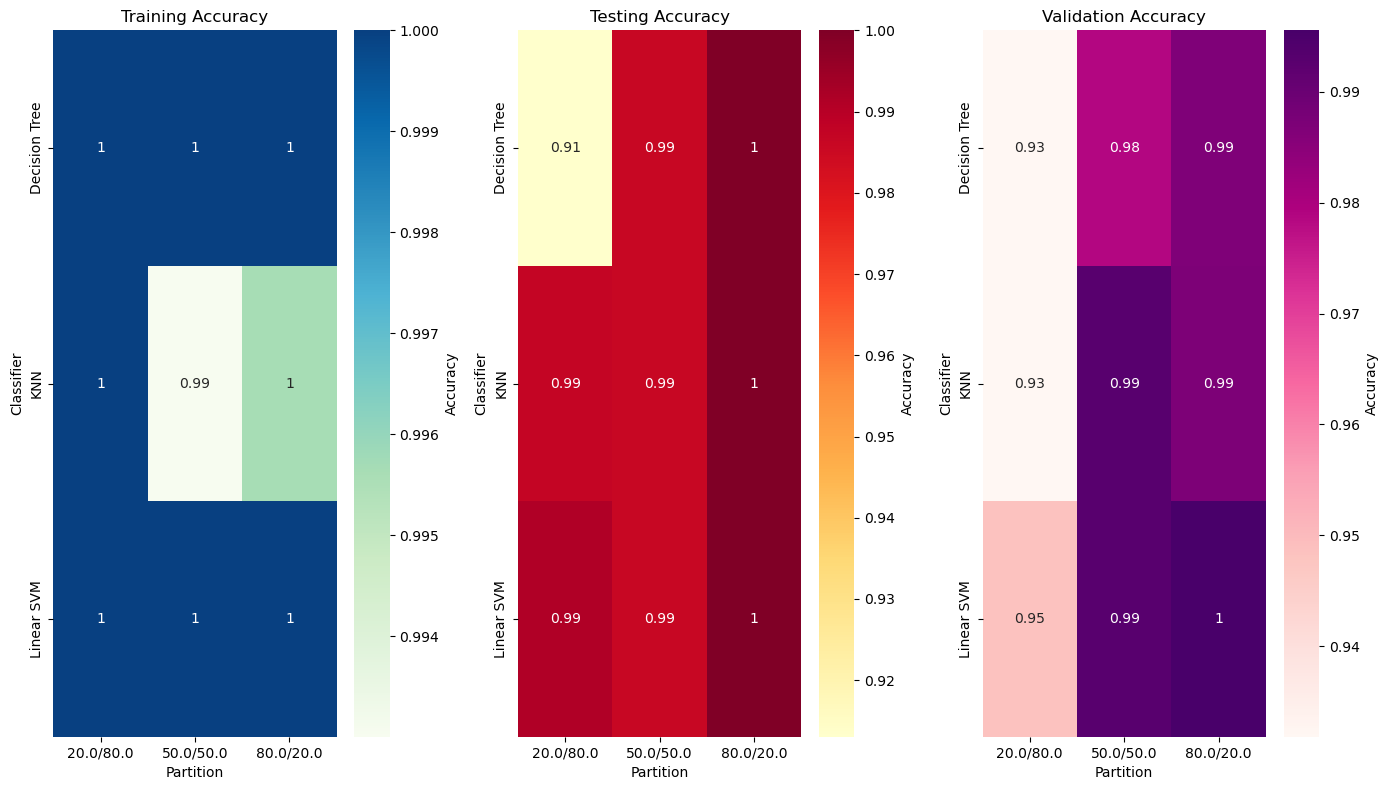

In [6]:
# Prepare data for visualization
# Extract the accuracy values from the results
data = {
    'Classifier': [],
    'Partition': [],
    'Training Accuracy': [],
    'Testing Accuracy': [],
    'Validation Accuracy': []
}

# Fill the data dictionary with accuracy results
for classifier_name, result_list in results.items():
    for result in result_list:
        data['Classifier'].append(classifier_name)
        data['Partition'].append(result['Train Size'])
        data['Training Accuracy'].append(result['Training Accuracy'])
        data['Testing Accuracy'].append(result['Testing Accuracy'])
        data['Validation Accuracy'].append(result['Validation Accuracy'])

# Convert to DataFrame for easier plotting
results_df = pd.DataFrame(data)

# Set up the figure for plotting multiple heatmaps
plt.figure(figsize=(14, 8))

# Pivot the data for easier plotting
train_acc_pivot = results_df.pivot("Classifier", "Partition", "Training Accuracy")
test_acc_pivot = results_df.pivot("Classifier", "Partition", "Testing Accuracy")
val_acc_pivot = results_df.pivot("Classifier", "Partition", "Validation Accuracy")

# Heatmap for Training Accuracy
plt.subplot(1, 3, 1)
sns.heatmap(train_acc_pivot, annot=True, cmap="GnBu", cbar_kws={'label': 'Accuracy'})
plt.title('Training Accuracy')

# Heatmap for Testing Accuracy
plt.subplot(1, 3, 2)
sns.heatmap(test_acc_pivot, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Accuracy'})
plt.title('Testing Accuracy')

# Heatmap for Validation Accuracy
plt.subplot(1, 3, 3)
sns.heatmap(val_acc_pivot, annot=True, cmap="RdPu", cbar_kws={'label': 'Accuracy'})
plt.title('Validation Accuracy')

# Show the plot
plt.tight_layout()
plt.show()